Normalized data range: -0.6421094536781311 to 0.600085437297821
Gain adjustment factor: 0.1957733154296875
Adjusted data range: -0.12570789456367493 to 0.11748071759939194
Adjusted audio saved as 'E:/音楽/この涙を君に捧ぐ/無名_ついなちゃん_Maine_VUoutput.wav'


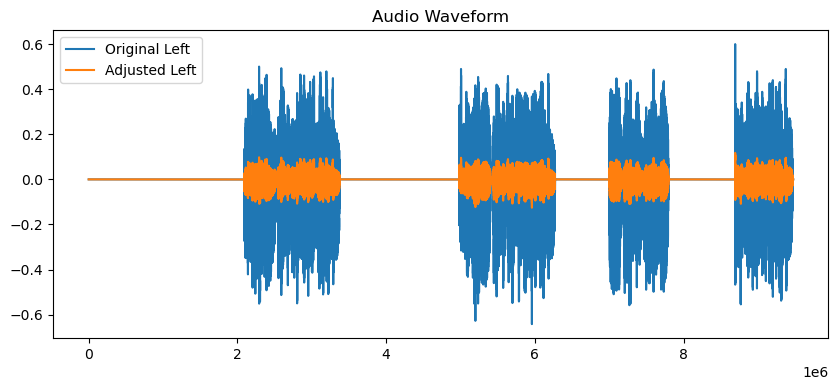

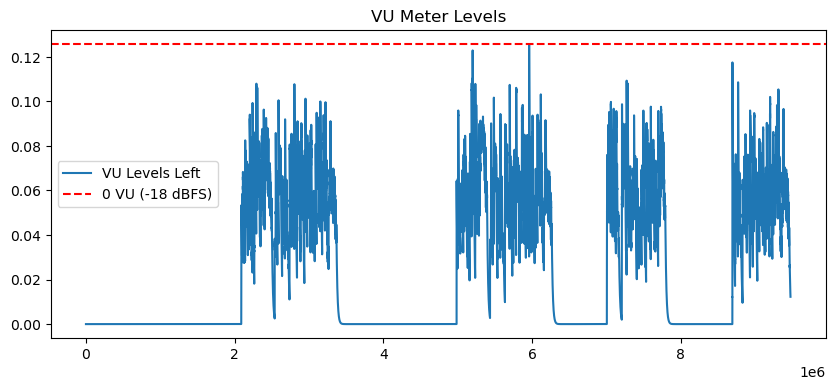

In [11]:
import os
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from tkinter import Tk, filedialog

# コンスタントの定義
VU_REF_DB = -18.0  # 0 VU を -18 dBFS に設定
REF_LEVEL = 10**(VU_REF_DB / 20)

# ファイル選択ダイアログを表示してファイルを選択する
root = Tk()
root.withdraw()  # メインウィンドウを表示しない
file_path = filedialog.askopenfilename(filetypes=[("WAV files", "*.wav")])
root.destroy()  # Tkinterウィンドウを破棄する

# オーディオファイルの読み込み
if file_path:
    rate, data = wav.read(file_path)
    if data.ndim == 1:
        data = np.expand_dims(data, axis=1)  # モノラルファイルの場合、チャンネルを追加

    # サンプルデータを -1～1 の範囲に正規化
    data = data.astype(np.float32) / np.iinfo(np.int16).max
    print(f"Normalized data range: {np.min(data)} to {np.max(data)}")

    # VU メーターフィルタ（約 300ms のリリースタイム）
    def vu_meter(signal, rate, release_time=0.3):
        alpha = np.exp(-1.0 / (release_time * rate))
        vu_level = np.zeros_like(signal)
        for i in range(1, len(signal)):
            vu_level[i] = max(alpha * vu_level[i-1], np.abs(signal[i]))
        return vu_level

    # VU メーターのレベルを計算
    def calculate_vu_levels(normalized_data):
        vu_levels = np.zeros_like(normalized_data)
        for ch in range(normalized_data.shape[1]):
            vu_levels[:, ch] = vu_meter(normalized_data[:, ch], rate)
        return vu_levels

    # 二分探索でゲインを調整
    def adjust_gain(normalized_data, ref_level=REF_LEVEL, tol=1e-3):
        low, high = 0.1, 10.0  # 初期のゲイン範囲
        while high - low > tol:
            mid = (low + high) / 2.0
            vu_levels = calculate_vu_levels(normalized_data * mid)
            max_vu = np.max(vu_levels)
            if max_vu < ref_level:
                low = mid
            else:
                high = mid
        return (low + high) / 2.0

    gain_adjustment = adjust_gain(data)
    print(f"Gain adjustment factor: {gain_adjustment}")

    # 統一したゲインを適用
    adjusted_data = data * gain_adjustment
    print(f"Adjusted data range: {np.min(adjusted_data)} to {np.max(adjusted_data)}")

    # 新しいファイル名を生成
    output_path = os.path.splitext(file_path)[0] + '_VUoutput.wav'

    # 調整後のオーディオデータを保存
    adjusted_data_int = np.int16(adjusted_data * np.iinfo(np.int16).max)
    wav.write(output_path, rate, adjusted_data_int)
    print(f"Adjusted audio saved as '{output_path}'")

    # プロットで結果を表示
    plt.figure(figsize=(10, 4))
    plt.plot(data[:, 0], label='Original Left')
    if data.shape[1] > 1:
        plt.plot(data[:, 1], label='Original Right')
    plt.plot(adjusted_data[:, 0], label='Adjusted Left')
    if adjusted_data.shape[1] > 1:
        plt.plot(adjusted_data[:, 1], label='Adjusted Right')
    plt.legend()
    plt.title('Audio Waveform')
    plt.show()

    plt.figure(figsize=(10, 4))
    vu_levels = calculate_vu_levels(adjusted_data)
    plt.plot(vu_levels[:, 0], label='VU Levels Left')
    if vu_levels.shape[1] > 1:
        plt.plot(vu_levels[:, 1], label='VU Levels Right')
    plt.axhline(y=REF_LEVEL, color='r', linestyle='--', label='0 VU (-18 dBFS)')
    plt.legend()
    plt.title('VU Meter Levels')
    plt.show()